In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


### Looking for a link between digital 3 and default

In [76]:
# Load diagnostic data from round 1
df_round1 = pd.read_csv("Round1_Diagnostic_23.csv")

df_round1.head()

,id,own,competing1,competing3,borrowertype,accepted,default,profit
0,1,0.0422,0.027688,0.131479,3,0,0,NaN
1,2,0.2069,0.967304,NaN,1,1,1,-10000.0
2,3,0.0578,0.028157,0.178069,3,0,0,NaN
3,4,0.0991,0.827000,0.657983,3,1,0,991.0
4,5,0.3684,1.000000,NaN,1,1,0,3684.0


In [77]:
# load old applications
old_applications = pd.read_csv("NewApplications_Lender3_Round1.csv")
old_applications.head()

,id,sex,employment,married,income,digital3
0,1,M,employed,0,29758,0.000000
1,2,F,retired,1,6140,0.000000
2,3,F,employed,1,27186,0.000000
3,4,M,employed,1,8429,0.734011
4,5,M,retired,1,2820,0.000000


In [78]:
df_round1 = df_round1.merge(old_applications, on='id', how='left')
df_round1.head()

,id,own,competing1,competing3,borrowertype,accepted,default,profit,sex,employment,married,income,digital3
0,1,0.0422,0.027688,0.131479,3,0,0,NaN,M,employed,0,29758,0.000000
1,2,0.2069,0.967304,NaN,1,1,1,-10000.0,F,retired,1,6140,0.000000
2,3,0.0578,0.028157,0.178069,3,0,0,NaN,F,employed,1,27186,0.000000
3,4,0.0991,0.827000,0.657983,3,1,0,991.0,M,employed,1,8429,0.734011
4,5,0.3684,1.000000,NaN,1,1,0,3684.0,M,retired,1,2820,0.000000


In [79]:
# Filter to keep deals we won
df_accepted = df_round1[df_round1["accepted"] == 1]

# Create a column to show when we don't have information for digital 3
df_accepted['missing_digital3'] = (df_accepted['digital3'] == 0).astype(int)

# Calculate default rate depending on if we have digital 3 or not
default_rate_by_digital3 = df_accepted.groupby('missing_digital3')['default'].mean()
count_by_digital3 = df_accepted.groupby('missing_digital3')['default'].count()

print("Default rate for loans accepted according to the presence of digital3 :")
print(default_rate_by_digital3)
print("\nNumber of loans in each category (digital3 present or missing) :")
print(count_by_digital3)

Default rate for loans accepted according to the presence of digital3 :
missing_digital3
0    0.102124
1    0.073674
Name: default, dtype: float64

Number of loans in each category (digital3 present or missing) :
missing_digital3
0    47315
1     8144
Name: default, dtype: int64


<ipython-input-79-eee47bdece53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted['missing_digital3'] = (df_accepted['digital3'] == 0).astype(int)


We initially considered adding a fee for applicants with missing digital3 data, assuming that the absence of this information would correlate with a higher risk of default. However, after analyzing the data, we found the opposite: applicants without digital3 data actually showed a lower default rate compared to those with it. Therefore, adding a fee in this case would be a mistake, as it would unfairly penalize potentially lower-risk applicants and make our offers less competitive.

### Optimizing offer threshold

In [80]:
# Define a function to simulate loan acceptance based on competition and borrower type
def simulate_acceptance(row):
    # Apply borrower preference adjustments to competing offers
    if row['borrowertype'] == 2:
        adjusted_own_rate = row['own'] - 0.02
        adjusted_competing1 = row['competing1']
        adjusted_competing3 = row['competing3']
    elif row['borrowertype'] == 1:
        adjusted_own_rate = row['own']
        adjusted_competing1 = row['competing1'] - 0.02 if not pd.isna(row['competing1']) else row['competing1']
        adjusted_competing3 = row['competing3']
    else:  # borrowertype == 3
        adjusted_own_rate = row['own']
        adjusted_competing1 = row['competing1']
        adjusted_competing3 = row['competing3'] - 0.02 if not pd.isna(row['competing3']) else row['competing3']

    # Determine the lowest adjusted rate offered (among non-null values)
    available_rates = [adjusted_own_rate, adjusted_competing1, adjusted_competing3]
    available_rates = [rate for rate in available_rates if pd.notnull(rate)]

    # If no rates are available, return 0 (no acceptance)
    if not available_rates:
        return 0

    # Find the best rate and check if our adjusted rate is the best (or tied for best)
    best_rate = min(available_rates)
    return 1 if adjusted_own_rate == best_rate else 0

# Apply the acceptance simulation to each row in the dataset
df_round1['accepted'] = df_round1.apply(simulate_acceptance, axis=1)

# Define function to calculate profit based on default and acceptance conditions
def calculate_profit(row):
    if row['accepted'] == 1:
        if row['default'] == 0:
            return row['own'] * 10000  # Profit if no default
        else:
            return -10000  # Loss if default
    return 0  # No profit if the offer wasn't accepted

# Apply the profit calculation
df_round1['profit'] = df_round1.apply(calculate_profit, axis=1)

# Calculate the simulated total profit and market share for Round 1
simulated_total_profit = df_round1['profit'].sum()
simulated_market_share = df_round1['accepted'].mean() * 100

# Display results to verify against actual Round 1 results
print(f"Simulated total profit for Round 1: {simulated_total_profit}")
print(f"Simulated market share for Round 1: {simulated_market_share:.2f}%")


Simulated total profit for Round 1: 13883094.99841
Simulated market share for Round 1: 55.46%


In [81]:
# Initialize lists to store threshold and corresponding profit values
thresholds = []
profits = []

# Iterate over threshold values from 0.10 to 0.40 (in increments of 0.01)
for threshold in [i / 100 for i in range(30, 40)]:
    # Filter out rows where the estimated probability of default is above the threshold
    df_threshold = df_round1[df_round1['own'] < threshold].copy()

    # Apply the acceptance simulation to the filtered data
    df_threshold['accepted'] = df_threshold.apply(simulate_acceptance, axis=1)

    # Recalculate profit for the thresholded dataset
    df_threshold['profit'] = df_threshold.apply(calculate_profit, axis=1)
    total_profit = df_threshold['profit'].sum()

    # Store threshold and profit
    thresholds.append(threshold)
    profits.append(total_profit)

# Identify the optimal threshold that maximizes profit
optimal_threshold = thresholds[profits.index(max(profits))]
print(f"Optimal default probability threshold: {optimal_threshold}")
print(f"Maximum profit at optimal threshold: {max(profits)}")


Optimal default probability threshold: 0.38
Maximum profit at optimal threshold: 13883094.998409998


In this step, we optimize the default probability threshold to identify the level beyond which offering a loan becomes unprofitable due to the high risk of default. The goal is to maximize profit by avoiding loans with an excessive default risk, while still capturing a reasonable market share.

Methodology:
Iterate Over Possible Thresholds: We evaluate thresholds ranging from 0.10 to 0.35 in increments of 0.01. For each threshold, we simulate the loan acceptance process, excluding borrowers whose estimated probability of default is above the threshold.
Simulate Loan Selection: For each borrower below the threshold, we simulate the competitive loan selection process, considering competitor rates and borrower type preferences (which allow certain borrowers to accept slightly higher rates from their preferred lender).
Calculate Profit: For each threshold scenario, we calculate the total profit by summing the profit from accepted loans. Profit is computed as the interest rate times the loan amount (10,000) if there’s no default, or -10,000 if the borrower defaults.
Select Optimal Threshold: We select the threshold that results in the highest total profit.
Result:
After running the simulations, we found that the optimal threshold for default probability is 0.38. This threshold maximizes profit by balancing risk reduction and market share retention.

### Merging and preprocessing data

In [82]:
# Load data
df_original = pd.read_csv("PastLoans.csv")
df_round1_training = pd.read_csv("Round1_Training.csv")

In [83]:
df_original.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,M,unemployed,0,0,0.749267,0.422656,0.738735,0
1,M,employed,1,26108,0.697428,0.596361,0.733947,0
2,M,employed,1,11810,0.000000,0.652496,0.000000,0
3,M,unemployed,1,0,0.000000,0.000000,0.000000,0
4,F,retired,1,6310,0.000000,0.041123,0.203202,0


In [84]:
df_round1_training.head()

,id,sex,employment,married,income,digital3,default
0,1,M,employed,0,29758,0.000000,0
1,2,F,retired,1,6140,0.000000,1
2,3,F,employed,1,27186,0.000000,0
3,4,M,employed,1,8429,0.734011,0
4,5,M,retired,1,2820,0.000000,0


In [85]:
df = pd.concat([df_original, df_round1_training], axis=0)
df.reset_index(drop=True, inplace=True)

In [86]:
df.drop('id', inplace=True, axis=1)
df.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,M,unemployed,0,0,0.749267,0.422656,0.738735,0
1,M,employed,1,26108,0.697428,0.596361,0.733947,0
2,M,employed,1,11810,0.000000,0.652496,0.000000,0
3,M,unemployed,1,0,0.000000,0.000000,0.000000,0
4,F,retired,1,6310,0.000000,0.041123,0.203202,0


In [87]:
# Redo feature engineering as for round 1
df["log_income"] = np.log1p(df["income"])
df["income"] = StandardScaler().fit_transform(df["income"].values.reshape(-1, 1))

# Encoding
df = pd.get_dummies(df, columns=["employment", "sex"], drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   married                200000 non-null  int64  
 1   income                 200000 non-null  float64
 2   digital1               100000 non-null  float64
 3   digital2               100000 non-null  float64
 4   digital3               200000 non-null  float64
 5   default                200000 non-null  int64  
 6   log_income             200000 non-null  float64
 7   employment_retired     200000 non-null  bool   
 8   employment_student     200000 non-null  bool   
 9   employment_unemployed  200000 non-null  bool   
 10  sex_M                  200000 non-null  bool   
dtypes: bool(4), float64(5), int64(2)
memory usage: 11.4 MB


In [88]:
# Remplace 0 values in digital3
def replace_digital3(row):
    if row["digital3"] == 0:
        if row["digital1"] != 0 and row["digital2"] != 0:
            return (row["digital1"] + row["digital2"]) / 2
        elif row["digital1"] != 0:
            return row["digital1"]
        elif row["digital2"] != 0:
            return row["digital2"]
    return row["digital3"]

df["digital3"] = df.apply(replace_digital3, axis=1)

df.drop(["digital1", "digital2"], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   married                200000 non-null  int64  
 1   income                 200000 non-null  float64
 2   digital3               179065 non-null  float64
 3   default                200000 non-null  int64  
 4   log_income             200000 non-null  float64
 5   employment_retired     200000 non-null  bool   
 6   employment_student     200000 non-null  bool   
 7   employment_unemployed  200000 non-null  bool   
 8   sex_M                  200000 non-null  bool   
dtypes: bool(4), float64(3), int64(2)
memory usage: 8.4 MB


As for the applications of round 1 we don't have digital 1 and 2, we sometime have no values for digital 3

In [89]:
# Checking for correlations
correlations = df.corr()
print(correlations["digital3"])

married                 -0.112188
income                  -0.016332
digital3                 1.000000
default                 -0.075282
log_income              -0.159819
employment_retired      -0.392135
employment_student       0.283163
employment_unemployed    0.008882
sex_M                    0.014083
Name: digital3, dtype: float64


In [90]:
df.describe()

,married,income,digital3,default,log_income
count,200000.000000,2.000000e+05,179065.000000,200000.000000,200000.000000
mean,0.609590,-1.664446e-17,0.516939,0.099475,7.856798
std,0.487843,1.000003e+00,0.273723,0.299299,3.654874
min,0.000000,-3.825094e-01,0.000000,0.000000,0.000000
25%,0.000000,-2.724978e-01,0.277891,0.000000,8.589514
50%,1.000000,-1.909001e-01,0.550547,0.000000,9.144307
75%,1.000000,-2.510479e-02,0.739409,0.000000,9.767668
max,1.000000,2.008857e+01,0.999994,1.000000,13.815512


In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Supposons que 'df' contienne les données complètes (train et test combinés)
# Filtrer les lignes où la valeur de 'digital3' est connue ou inconnue
df_known_digital3 = df[(df["digital3"] != 0) & (df["digital3"].notna())]
df_missing_digital3 = df[(df["digital3"] == 0) | (df["digital3"].isna())]

# Créer X et y pour l’imputation en excluant la variable 'default'
X_impute = df_known_digital3.drop(["digital3", "default"], axis=1)
y_impute = df_known_digital3["digital3"]

# Ajouter des composantes principales (PCA) pour l’imputation
pca = PCA(n_components=2)
X_impute_pca = pca.fit_transform(X_impute)
X_impute_pca_df = pd.DataFrame(X_impute_pca, columns=["PCA1", "PCA2"], index=X_impute.index)

# Ajouter les composantes PCA à X_impute
X_impute = pd.concat([X_impute, X_impute_pca_df], axis=1)

# Séparer les données d’entraînement et de validation pour l’imputation
X_train_impute, X_val_impute, y_train_impute, y_val_impute = train_test_split(
    X_impute, y_impute, test_size=0.2, random_state=42
)

# Entraîner le modèle d'imputation sur l’ensemble où 'digital3' est connu
model_impute = RandomForestRegressor(random_state=42)
model_impute.fit(X_train_impute, y_train_impute)

# Évaluer les performances du modèle d'imputation
y_val_pred_impute = model_impute.predict(X_val_impute)
imputation_mse = mean_squared_error(y_val_impute, y_val_pred_impute)
print(f"MSE of imputation model for digital3 : {imputation_mse:.4f}")

# Appliquer le modèle d'imputation aux lignes avec 'digital3' manquant (digital3 == 0)
X_missing = df_missing_digital3.drop(["digital3", "default"], axis=1)

# Appliquer le même PCA pour générer des composantes sur le test set
X_missing_pca = pca.transform(X_missing)
X_missing_pca_df = pd.DataFrame(X_missing_pca, columns=["PCA1", "PCA2"], index=X_missing.index)

# Ajouter les composantes PCA à X_missing
X_missing = pd.concat([X_missing, X_missing_pca_df], axis=1)

# Prédire les valeurs manquantes de 'digital3'
df_missing_digital3["digital3"] = model_impute.predict(X_missing)

# Rejoindre les données imputées et les données connues
df_imputed = pd.concat([df_known_digital3, df_missing_digital3]).sort_index()

# Vérifier la distribution de 'digital3' après l'imputation
print("Distribution of digital3 after imputation :")
print(df_imputed["digital3"].describe())

# Copier les données complètes avec valeurs imputées dans 'df'
df = df_imputed.copy()

# Préparation de X et y pour l'entraînement du modèle final
X = df.drop("default", axis=1)
y = df["default"]

# Entraînement d'un nouveau PCA sur les données complètes (optionnel si souhaité pour d'autres caractéristiques)
pca_final = PCA(n_components=2)
X_pca_final = pca_final.fit_transform(X)
X_pca_final_df = pd.DataFrame(X_pca_final, columns=["PCA1", "PCA2"], index=X.index)

# Ajout des composantes PCA finales à X
X = pd.concat([X, X_pca_final_df], axis=1)

# Vérification des informations de X final
X.info()


MSE of imputation model for digital3 : 0.0754
Distribution of digital3 after imputation :
count    200000.000000
mean          0.514471
std           0.263928
min           0.000006
25%           0.283987
50%           0.542644
75%           0.722171
max           0.999994
Name: digital3, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   married                200000 non-null  int64  
 1   income                 200000 non-null  float64
 2   digital3               200000 non-null  float64
 3   log_income             200000 non-null  float64
 4   employment_retired     200000 non-null  bool   
 5   employment_student     200000 non-null  bool   
 6   employment_unemployed  200000 non-null  bool   
 7   sex_M                  200000 non-null  bool   
 8   PCA1                   200000 non-null  float64
 9   P

<ipython-input-91-48eb1f358163>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_digital3["digital3"] = model_impute.predict(X_missing)


In [92]:
joblib.dump(pca_final, "pca_model_round2.pkl")

['pca_model_round2.pkl']

In [93]:
joblib.dump(model_impute, "model_impute_round2.pkl")

['model_impute_round2.pkl']

In [94]:
joblib.dump(pca, "pca_model_for_imputation.pkl")

['pca_model_for_imputation.pkl']

In [95]:
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Retraining dataset using all the data available

In [96]:
!pip install optuna

In [97]:
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from imblearn.over_sampling import SMOTE

# define objective function
def objective(trial):
    # Optimization parameters
    hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 50, 200)
    activation = trial.suggest_categorical("activation", ["logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-3, log=True)

    # Model creation
    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_sizes,),
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=1000,
        random_state=42
    )

    # Resample the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train and evaluate
    mlp.fit(X_train_resampled, y_train_resampled)
    y_val_pred = mlp.predict(X_val)

    # Optimize Recall for class 1 only
    score = recall_score(y_val, y_val_pred, pos_label=1, average="binary")

    return score

# Use Optuna for optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

# Best params
best_params = study.best_params
print("Meilleurs paramètres : ", best_params)


# Use Optuna for optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

# Best params
best_params = study.best_params
print("Meilleurs paramètres : ", best_params)

[I 2024-11-03 10:47:56,213] A new study created in memory with name: no-name-e816035f-22e0-48cf-b9ea-c8d96913456b
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-11-03 11:00:47,370] Trial 0 finished with value: 0.7604925860769037 and parameters: {'hidden_layer_sizes': 87, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0002324729743379065}. Best is trial 0 with value: 0.7604925860769037.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

KeyboardInterrupt: 

In [98]:
best_params = {'hidden_layer_sizes': 53, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00032613911654113186}

In [99]:
# Retrain the model with best parameters
mlp_best = MLPClassifier(
    hidden_layer_sizes=(best_params["hidden_layer_sizes"],),
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    max_iter=1000,
    random_state=42
)
mlp_best.fit(X, y)

# Save optimzed model
import joblib
joblib.dump(mlp_best, "mlp_best_model_round2.pkl")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


['mlp_best_model_round2.pkl']

In [100]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrated classifier using sigmoid method
calibrated_model = CalibratedClassifierCV(mlp_best, method="sigmoid", cv=5)  # Use "prefit" as we've already trained the model
calibrated_model.fit(X_train, y_train)  # Calibrate on the validation set

# Save the calibrated model
import joblib
joblib.dump(calibrated_model, "calibrated_mlp_best_model_round2.pkl")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

['calibrated_mlp_best_model_round2.pkl']

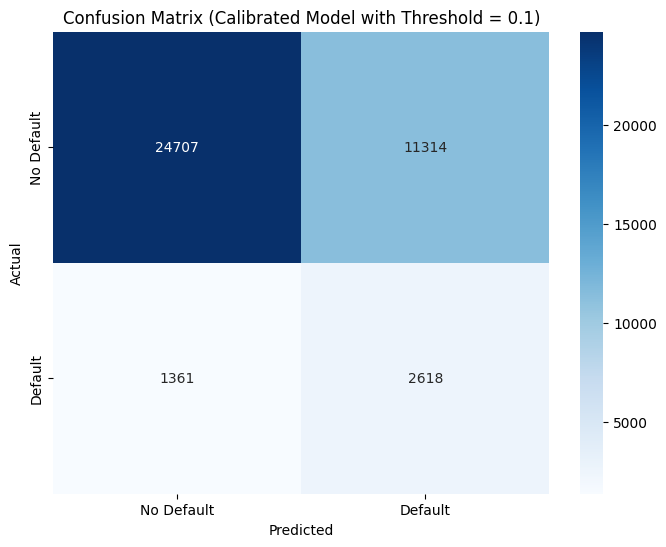

Classification Report (Calibrated Model with Threshold = 0.1):
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     36021
           1       0.19      0.66      0.29      3979

    accuracy                           0.68     40000
   macro avg       0.57      0.67      0.54     40000
weighted avg       0.87      0.68      0.75     40000

ROC AUC Score (Calibrated Model): 0.7422


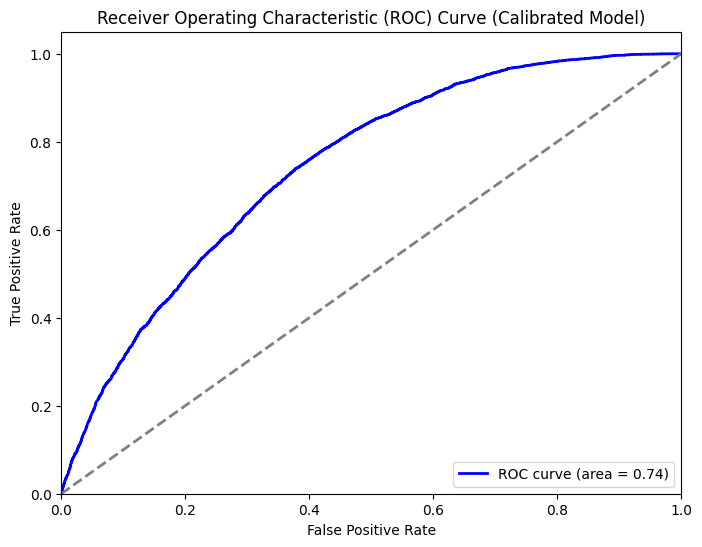

In [101]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choisissez le seuil de décision
threshold = 0.50

# Performance on the validation set
y_val_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe 1

# Appliquez le seuil personnalisé
y_val_pred_thresholded = (y_val_proba_calibrated >= threshold).astype(int)

# Confusion matrix avec seuil ajusté
cm = confusion_matrix(y_val, y_val_pred_thresholded)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title(f"Confusion Matrix (Calibrated Model with Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report pour le modèle avec seuil ajusté
print(f"Classification Report (Calibrated Model with Threshold = {threshold}):")
print(classification_report(y_val, y_val_pred_thresholded))

# ROC AUC score pour le modèle calibré (sans ajustement de seuil, car ROC AUC utilise les probabilités)
roc_auc_calibrated = roc_auc_score(y_val, y_val_proba_calibrated)
print(f"ROC AUC Score (Calibrated Model): {roc_auc_calibrated:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_calibrated)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_calibrated:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (Calibrated Model)")
plt.legend(loc="lower right")
plt.show()

Brier Score (Calibrated Model): 0.0842


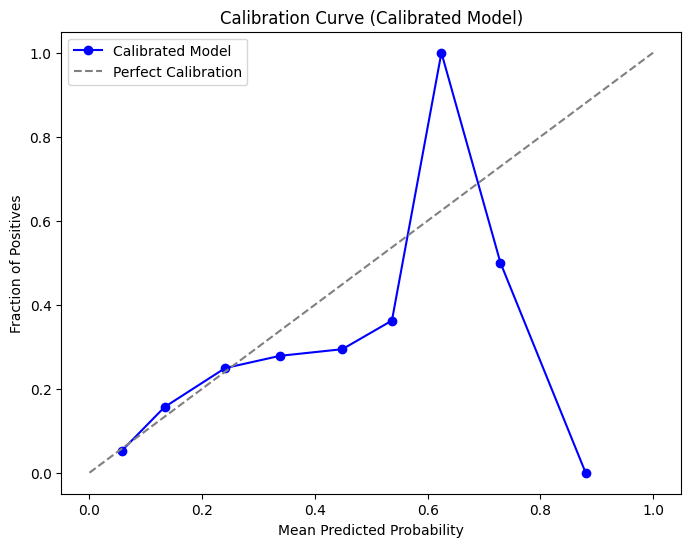

In [102]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Probabilités de défaut pour le modèle calibré
y_val_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe "Default"

# Brier Score
brier_score = brier_score_loss(y_val, y_val_proba_calibrated)
print(f"Brier Score (Calibrated Model): {brier_score:.4f}")

# Diagramme de Calibration
prob_true, prob_pred = calibration_curve(y_val, y_val_proba_calibrated, n_bins=10, strategy="uniform")

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", color="blue", label="Calibrated Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Calibrated Model)")
plt.legend(loc="upper left")
plt.show()


### Retraining dataset using all the data available and with brier score as objective

In [103]:
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import brier_score_loss

# define objective function
def objective(trial):
    # Optimization parameters
    hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 50, 200)
    activation = trial.suggest_categorical("activation", ["logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-3, log=True)

    # Model creation
    mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_sizes,),
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=1000,
        random_state=42
    )

    # Resample the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train and evaluate
    mlp.fit(X_train_resampled, y_train_resampled)
    y_val_proba = mlp.predict_proba(X_val)[:, 1]

    # Optimize Brier score
    score = brier_score_loss(y_val, y_val_proba)

    return score

# Use Optuna for optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best params
best_params = study.best_params
print("Meilleurs paramètres : ", best_params)


# Use Optuna for optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Best params
best_params = study.best_params
print("Meilleurs paramètres : ", best_params)

[I 2024-11-03 12:20:31,455] A new study created in memory with name: no-name-5f2c2bee-b5ce-49e0-916d-728cc856736d
[I 2024-11-03 12:23:45,067] Trial 0 finished with value: 0.2210039923961331 and parameters: {'hidden_layer_sizes': 200, 'activation': 'relu', 'solver': 'adam', 'alpha': 8.703138543778882e-05}. Best is trial 0 with value: 0.2210039923961331.
[I 2024-11-03 12:26:30,435] Trial 1 finished with value: 0.2168232416159508 and parameters: {'hidden_layer_sizes': 196, 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.2504102072596065e-05}. Best is trial 0 with value: 0.2210039923961331.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.

KeyboardInterrupt: 

In [104]:
best_params = {'hidden_layer_sizes': 178, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.00014693708473873863}

In [105]:
# Retrain the model with best parameters
mlp_best = MLPClassifier(
    hidden_layer_sizes=(best_params["hidden_layer_sizes"],),
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    max_iter=1000,
    random_state=42
)
mlp_best.fit(X, y)

# Save optimzed model
import joblib
joblib.dump(mlp_best, "mlp_best_model_round2_brier.pkl")

['mlp_best_model_round2_brier.pkl']

In [106]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrated classifier using sigmoid method
calibrated_model = CalibratedClassifierCV(mlp_best, method="sigmoid", cv=5)  # Use "prefit" as we've already trained the model
calibrated_model.fit(X_train, y_train)  # Calibrate on the validation set

# Save the calibrated model
import joblib
joblib.dump(calibrated_model, "calibrated_mlp_best_model_round2_brier.pkl")

['calibrated_mlp_best_model_round2_brier.pkl']

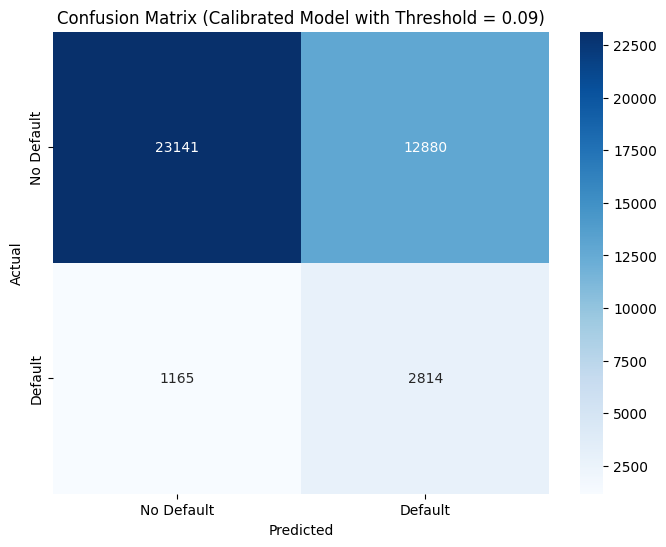

Classification Report (Calibrated Model with Threshold = 0.09):
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     36021
           1       0.18      0.71      0.29      3979

    accuracy                           0.65     40000
   macro avg       0.57      0.67      0.53     40000
weighted avg       0.88      0.65      0.72     40000

ROC AUC Score (Calibrated Model): 0.7412


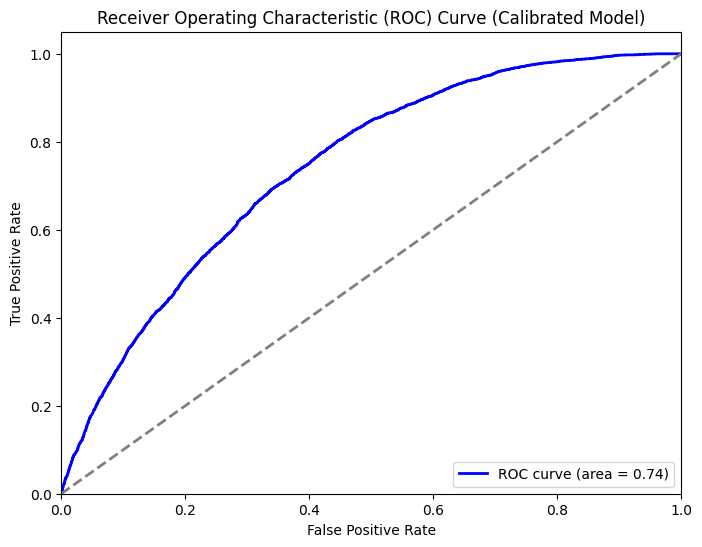

In [119]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choisissez le seuil de décision
threshold = 0.09  # Ajustez ce seuil selon vos besoins

# Performance on the validation set
y_val_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe 1

# Appliquez le seuil personnalisé
y_val_pred_thresholded = (y_val_proba_calibrated >= threshold).astype(int)

# Confusion matrix avec seuil ajusté
cm = confusion_matrix(y_val, y_val_pred_thresholded)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title(f"Confusion Matrix (Calibrated Model with Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report pour le modèle avec seuil ajusté
print(f"Classification Report (Calibrated Model with Threshold = {threshold}):")
print(classification_report(y_val, y_val_pred_thresholded))

# ROC AUC score pour le modèle calibré (sans ajustement de seuil, car ROC AUC utilise les probabilités)
roc_auc_calibrated = roc_auc_score(y_val, y_val_proba_calibrated)
print(f"ROC AUC Score (Calibrated Model): {roc_auc_calibrated:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_calibrated)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_calibrated:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (Calibrated Model)")
plt.legend(loc="lower right")
plt.show()

Brier Score (Calibrated Model): 0.0842


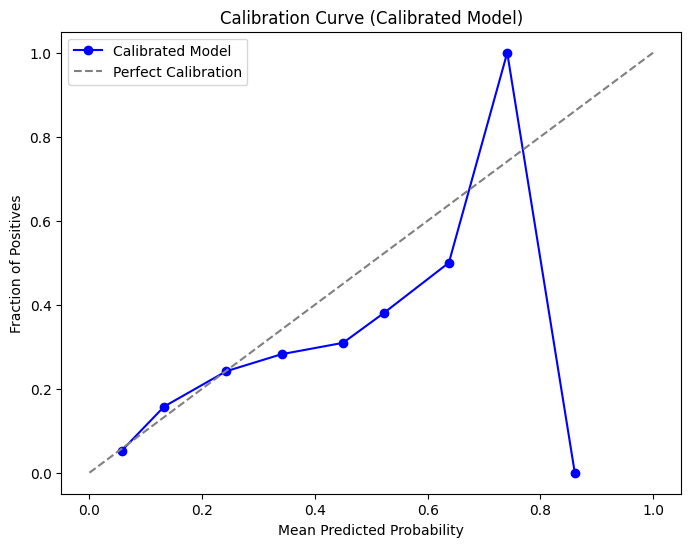

In [108]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Probabilités de défaut pour le modèle calibré
y_val_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe "Default"

# Brier Score
brier_score = brier_score_loss(y_val, y_val_proba_calibrated)
print(f"Brier Score (Calibrated Model): {brier_score:.4f}")

# Diagramme de Calibration
prob_true, prob_pred = calibration_curve(y_val, y_val_proba_calibrated, n_bins=10, strategy="uniform")

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", color="blue", label="Calibrated Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Calibrated Model)")
plt.legend(loc="upper left")
plt.show()


### Prediction for round 2

In [111]:
# Charger les données
df_new_applications = pd.read_csv("NewApplications_Lender2_Round2.csv")

# Définir "id" comme index et supprimer "digital2"
df_new_applications.set_index("id", inplace=True)

# Appliquer le prétraitement
df_new_applications["log_income"] = np.log1p(df_new_applications["income"])
df_new_applications["income"] = StandardScaler().fit_transform(df_new_applications["income"].values.reshape(-1, 1))
df_new_applications = pd.get_dummies(df_new_applications, columns=["employment", "sex"], drop_first=True)
df_new_applications["digital3"] = df_new_applications["digital2"]  #Apparently we changed team but we need the same feature name

df_new_applications.drop(columns=["digital2"], inplace=True)

In [112]:
import joblib
import pandas as pd

# Charger le modèle PCA pour l'imputation
pca_impute = joblib.load("pca_model_for_imputation.pkl")

# Charger le modèle d'imputation pour 'digital3'
model_impute = joblib.load("model_impute_round2.pkl")

# Filtrer les colonnes pour le modèle d'imputation (sans 'digital3' et sans 'default')
X_new_impute = df_new_applications.drop(["digital3", "default"], axis=1, errors='ignore')

# Appliquer le PCA aux colonnes nécessaires pour l'imputation de digital3
X_new_impute_pca = pca_impute.transform(X_new_impute)
X_new_impute_pca_df = pd.DataFrame(X_new_impute_pca, columns=["PCA1", "PCA2"], index=X_new_impute.index)

# Ajouter les composantes PCA à X_new_impute pour l’imputation de 'digital3'
X_new_impute = pd.concat([X_new_impute, X_new_impute_pca_df], axis=1)

# Filtrer les lignes avec 'digital3' manquant (digital3 == 0)
digital3_missing_indices = df_new_applications[df_new_applications["digital3"] == 0].index
X_missing_impute = X_new_impute.loc[digital3_missing_indices]

# Imputer les valeurs manquantes de 'digital3'
df_new_applications.loc[digital3_missing_indices, "digital3"] = model_impute.predict(X_missing_impute)

# Charger le modèle PCA principal pour les nouvelles composantes
pca = joblib.load("pca_model_round2.pkl")

# Assurer l'alignement des colonnes avec celles utilisées lors de l'entraînement du PCA
pca_columns = pca.feature_names_in_
df_new_applications_pca = df_new_applications[pca_columns]

# Appliquer la transformation PCA
X_new_pca = pca.transform(df_new_applications_pca)

# Créer un DataFrame avec les nouvelles composantes PCA
X_new_df_pca = pd.DataFrame(X_new_pca, columns=["PCA1", "PCA2"], index=df_new_applications.index)

# Réintégrer les colonnes PCA dans le DataFrame final
df_new_with_pca = pd.concat([df_new_applications, X_new_df_pca], axis=1)

# Charger les colonnes du modèle MLP pour assurer l'ordre correct
mlp = joblib.load("calibrated_mlp_best_model_round2.pkl")
mlp_columns = mlp.feature_names_in_

# Aligner les colonnes de df_new_with_pca selon l'ordre attendu par le MLP
X_new = df_new_with_pca[mlp_columns]

# Effectuer les prédictions
y_pred_proba = mlp.predict_proba(X_new)[:, 1]


In [113]:
X_new.head()

,married,income,digital3,log_income,employment_retired,employment_student,employment_unemployed,sex_M,PCA1,PCA2
id,,,,,,,,,,
100001,1,-0.217645,0.548265,9.004545,False,False,False,True,1.148335,-0.320891
100002,1,-0.122185,0.693039,9.456810,False,False,False,True,1.604480,-0.263033
100003,1,-0.061464,0.546165,9.664977,False,False,False,True,1.818413,-0.222825
100004,1,15.368169,0.602442,13.551759,False,False,False,False,7.053825,14.773905
100005,1,0.182118,0.551965,10.226802,False,False,False,True,2.398281,-0.029151


In [114]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100001 to 200000
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   married                100000 non-null  int64  
 1   income                 100000 non-null  float64
 2   digital3               100000 non-null  float64
 3   log_income             100000 non-null  float64
 4   employment_retired     100000 non-null  bool   
 5   employment_student     100000 non-null  bool   
 6   employment_unemployed  100000 non-null  bool   
 7   sex_M                  100000 non-null  bool   
 8   PCA1                   100000 non-null  float64
 9   PCA2                   100000 non-null  float64
dtypes: bool(4), float64(5), int64(1)
memory usage: 7.7 MB


In [115]:
def calculate_breakeven_rate(pd):
    return pd / (1 - pd)

def calculate_interest_rate(pd, breakeven_rate):
    if pd < 0.05:
        return breakeven_rate + 0.01
    elif pd < 0.1:
        return breakeven_rate + 0.02
    elif pd < 0.15:
        return breakeven_rate + 0.03
    elif pd < 0.2:
        return breakeven_rate + 0.04
    elif pd < 0.25: # corresponds to threshold of interest rate of 0,38 max
        return breakeven_rate + 0.05
    else:
        return None

# Calculate interest rates
predictions = pd.DataFrame({
    "id": df_new_applications.index,
    "estimated_probability_of_default": y_pred_proba
})

predictions["breakeven_rate"] = predictions["estimated_probability_of_default"].apply(calculate_breakeven_rate)
predictions["rate"] = predictions.apply(lambda x: calculate_interest_rate(
    x["estimated_probability_of_default"], x["breakeven_rate"]), axis=1)


In [116]:
# Create submission files
submissions = predictions[["id", "rate"]]
submissions["rate"] = submissions["rate"].apply(lambda x: round(x, 4) if pd.notnull(x) else None)
submissions.to_csv("submissions_round2.csv", index=False)

<ipython-input-116-38d490fed8db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions["rate"] = submissions["rate"].apply(lambda x: round(x, 4) if pd.notnull(x) else None)


### Compare both round predictions

In [123]:
import pandas as pd

# load interest rates
submissions_round1 = pd.read_csv("submissions_rounded.csv")
submissions_round2 = pd.read_csv("submissions_round2.csv")

print(submissions_round1.columns)
print(submissions_round2.columns)

Index(['id', 'rate'], dtype='object')
Index(['id', 'rate'], dtype='object')


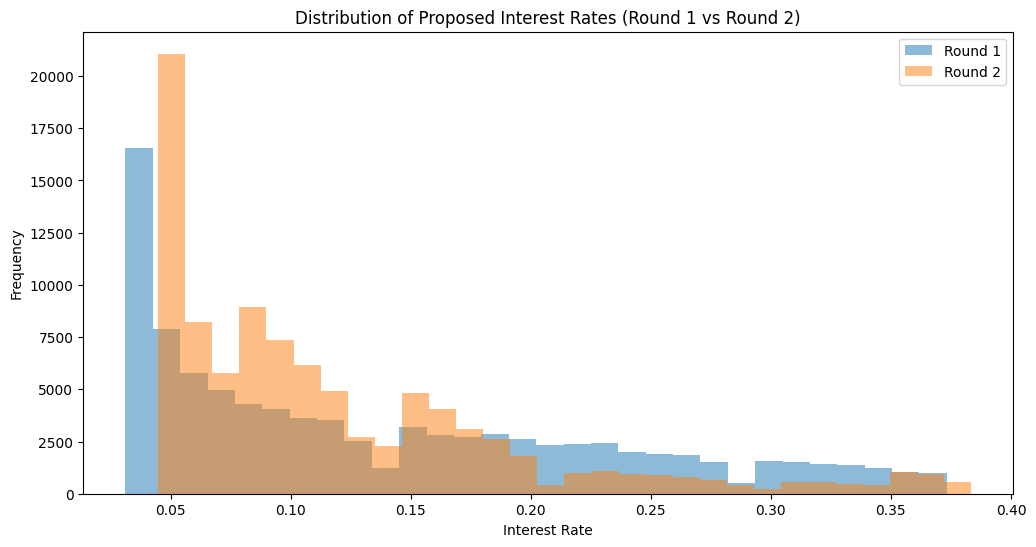

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(submissions_round1["rate"].dropna(), bins=30, alpha=0.5, label="Round 1")
plt.hist(submissions_round2["rate"].dropna(), bins=30, alpha=0.5, label="Round 2")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Proposed Interest Rates (Round 1 vs Round 2)")
plt.legend()
plt.show()

<ipython-input-125-a15d1de5c3e5>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(submissions_round1["rate"].dropna(), label="Round 1", shade=True)
<ipython-input-125-a15d1de5c3e5>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(submissions_round2["rate"].dropna(), label="Round 2", shade=True)


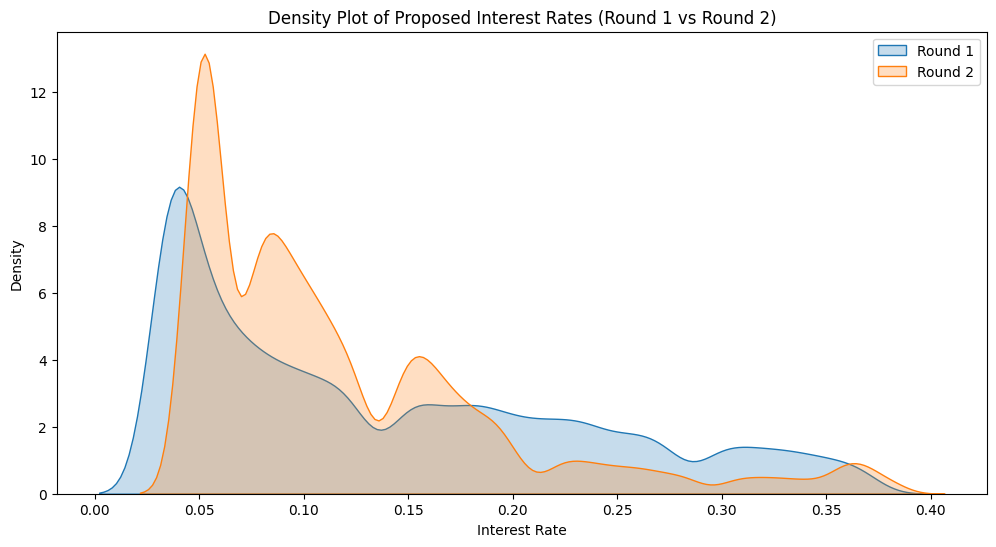

In [125]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(submissions_round1["rate"].dropna(), label="Round 1", shade=True)
sns.kdeplot(submissions_round2["rate"].dropna(), label="Round 2", shade=True)
plt.xlabel("Interest Rate")
plt.ylabel("Density")
plt.title("Density Plot of Proposed Interest Rates (Round 1 vs Round 2)")
plt.legend()
plt.show()

We have an higher distribution at the lowest interest rate and a lower at the lowest, which is what we wanted (I think)

In [126]:
submissions_round2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      100000 non-null  int64  
 1   rate    94939 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


### Results

MLP with recall as objective :
Brier Score (Calibrated Model): 0.0842
Classification Report (Calibrated Model with Threshold = 0.1):
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     36021
           1       0.19      0.66      0.29      3979

    accuracy                           0.68     40000
   macro avg       0.57      0.67      0.54     40000
weighted avg       0.87      0.68      0.75     40000

ROC AUC Score (Calibrated Model): 0.7422

MLP with brier score as objective. Brier Score (Calibrated Model): 0.0842
Classification Report (Calibrated Model with Threshold = 0.1):
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     36021
           1       0.19      0.65      0.29      3979

    accuracy                           0.69     40000
   macro avg       0.57      0.67      0.55     40000
weighted avg       0.87      0.69      0.75     40000

ROC AUC Score (Calibrated Model): 0.7412